# Table of Contents

1. [Imports](#import)
2. [Function for reading the csv files and dropping the unwanted columns](#readfile)
3. [Standardize the data](#standardise)
4. [Confusion Matrix, Classification Report and Accuracy Report](#confusionmatrix)
5. [Explanation of k-means and k-means++](#exp)
6. [Naive Bayes Classifier Explanation](#naive)
7. [Gaussian Naive Bayes Explanation](#gaus)
8. [Getiing the MLE for the Mean and the Variance](#mle)
9. [Naive Bayes Classifier Implementation](#impnaive)
10. [Plot the Confusion Matrix and print the Classification Report and Accuracy Score](#conf)
11. [Train and Prediction](#train)


### <a id="import"></a> Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.cluster import KMeans


### <a id="readfile"></a> Function for reading the csv files and dropping the unwanted columns

In [2]:
cols_to_drop = ['id', 'uri', 'duration_ms']
file_name = r"data\csvs\dataframeV1.csv"

def read_csv_files(file_name, cols_to_drop=cols_to_drop): 
    df = pd.read_csv(file_name, index_col=0)
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    labels = df['label']
    
    # This makes the categorical labels numbers. Print it to see... Better than labels.cat.codes
    y = labels.factorize()[0]
    
    # Add new axis to y in order to be able to transpose it when needed 
    # y = y[:, np.newaxis]
    return df, y

df, y = read_csv_files(file_name)
print(y)
df

[0 0 0 ... 3 3 3]


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,label
0,0.2750,0.1570,7,-18.752,1,0.0636,0.89000,0.842000,0.1860,0.3040,73.289,4,classic
1,0.2210,0.1260,0,-25.427,1,0.0447,0.98900,0.897000,0.1020,0.2160,133.630,4,classic
2,0.2890,0.0306,9,-30.790,0,0.0446,0.98700,0.911000,0.1020,0.1180,125.610,3,classic
3,0.0753,0.0700,2,-27.272,1,0.0440,0.91800,0.947000,0.1460,0.0625,79.801,4,classic
4,0.1300,0.1580,2,-16.132,1,0.0350,0.74800,0.924000,0.1000,0.0998,85.031,4,classic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.6510,0.7610,10,-7.801,1,0.2500,0.44600,0.000035,0.1110,0.8690,139.526,4,rap
46,0.8710,0.6390,7,-7.821,1,0.3490,0.12100,0.000000,0.1930,0.7640,141.060,4,rap
47,0.6170,0.4770,1,-9.889,1,0.3600,0.00422,0.000000,0.0830,0.4360,99.095,4,rap
48,0.8500,0.5640,1,-9.631,0,0.3830,0.23800,0.000000,0.1110,0.3480,139.920,4,rap


### <a id="standardise"></a> Standardize the data

We can drop the labels of our training data and then convert them on a single scale. We can standardize the values using the below formula.

$$x_i = \frac{{x}_i - mean(x)} {\sigma(x)} $$

It’s recommended to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any dataset would have different units of measurements such as age vs income.

In [5]:
X = df.drop(["label"], axis=1)

def standardise(X):
    # mean and standard deviation of all the features irrespective of class differences
    mean_all   = X.mean()  
    std_all    = X.std() 

    # standardised values
    X_standardised = (X-mean_all)/std_all
    return X_standardised

X_standardised = standardise(X)

X_standardised.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,-1.100925,-1.050292,0.511531,-0.834979,0.903018,-0.373430,1.090495,1.715003,0.113724,-0.370043,-1.362347,0.252684
1,-1.368146,-1.141622,-1.470268,-1.661467,0.903018,-0.563558,1.329736,1.869971,-0.530812,-0.735956,0.579970,0.252684
2,-1.031645,-1.422685,1.077759,-2.325506,-1.106597,-0.564564,1.324903,1.909417,-0.530812,-1.143451,0.321814,-1.850984
3,-2.089151,-1.306607,-0.904040,-1.889913,0.903018,-0.570600,1.158159,2.010851,-0.193198,-1.374226,-1.152733,0.252684
4,-1.818465,-1.047346,-0.904040,-0.510575,0.903018,-0.661137,0.747340,1.946046,-0.546158,-1.219128,-0.984384,0.252684


### <a id="naive"></a> Naive Bayes Classifier. 
Let's first get to know the calculations before the actual implementations.

Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values, where the class labels are drawn from some finite set. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable. For example, a fruit may be considered to be an apple if it is red, round, and about 10 cm in diameter. A naive Bayes classifier considers each of these features to contribute independently to the probability that this fruit is an apple, regardless of any possible correlations between the color, roundness, and diameter features.

Abstractly, naive Bayes is a conditional probability model: given a problem instance to be classified, represented by a vector $ {\displaystyle \mathbf {x} =(x_{1},\ldots ,x_{n})}$ representing some n features (independent variables), it assigns to this instance probabilities
$$ {\LARGE{ \displaystyle p(C_{k}\mid x_{1},\ldots ,x_{n})\,}}$$
for each of K possible outcomes or classes ${\displaystyle C_{k}}.$


Using Bayes' theorem, the conditional probability can be decomposed as
$$ {\displaystyle p(C_{k}\mid \mathbf {x} )={\frac {p(C_{k})\ p(\mathbf {x} \mid C_{k})}{p(\mathbf {x} )}}\,} $$
In plain English, using Bayesian probability terminology, the above equation can be written as
$$ {\displaystyle {\text{posterior}}={\frac {{\text{prior}}\times {\text{likelihood}}}{\text{evidence}}}\,} $$

In practice, there is interest only in the numerator of that fraction, because the denominator does not depend on ${\displaystyle C}$ and the values of the features $\mathbf{x_{i}}$ are given, so that the denominator is effectively constant. So the evidence,
$ {\displaystyle \sum _{k}p(C_{k})\ p(\mathbf {x} \mid C_{k})}$
is a scaling factor dependent only on ${\displaystyle x_{1},\ldots ,x_{n}}$, that is, a constant if the values of the feature variables are known. So we shall drop it since it does not influence the classification.

Again, in our case, since we have four classes each of which occuring with equal probability of $\frac{1}{4}$, we can see that the **prior**, $\mathbb{P}(\mathbf{C}_k)$, is effectively constant just like the evidence above. So, we shall drop it as well.


Now we have only the **likelihood**, $p(\mathbf {x} \mid C_{k})$ , to work with. The likelihood can be rewritten as follows, using the chain rule for repeated applications of the definition of conditional probability:

$$\displaystyle{p(x_1, x_2, \ldots, x_n \mid C_k) = p(x_{1}\mid x_{2},\ldots ,x_{n},C_{k})\ p(x_{2}\mid x_{3},\ldots ,x_{n},C_{k})\cdots p(x_{n-1}\mid x_{n},C_{k})\ p(x_{n}\mid C_{k})}$$

Now the **naive** conditional independence assumptions come into play: assume that all features in $\mathbf{x}$ are mutually independent, conditional on the category $\mathbf{C_{k}}$. Under this assumption,

$$\displaystyle {p(x_{i}\mid x_{i+1},\ldots ,x_{n},C_{k})=p(x_{i}\mid C_{k})\,}.$$

Thus, the joint model, after dropping the prior and the evidence, can be expressed as **proportional** to $\prod _{i=1}^{n}p(x_{i}\mid C_{k})$


Which Distribution should we use for the joint model **proportional** to $\prod _{i=1}^{n}p(x_{i}\mid C_{k})$? Even though there are many distributions to use here, we opt for Gaussian Naive Bayes.

### <a id="gaus"></a> Gaussian Naive Bayes.

When dealing with continuous data, a typical assumption is that the continuous values associated with each class are distributed according to a normal (or Gaussian) distribution. For example, suppose the training data contains a continuous attribute, $\mathbf{x}$. The data is first **segmented** by the class, and then the **mean** and **variance** of $\mathbf{x}$ is computed in each class. Let $\mathbf{\mu _{k}}$ be the mean of the values in $\mathbf{x}$ associated with class $\mathbf{C}_k $, and let $\mathbf{\sigma}_{k}^{2}$ be the unbiased sample variance of the values in $\mathbf{x}$ associated with class $\mathbf{C}_k $ (that is, the degree of freedom is 1 => n-1). Suppose one has collected some observation value v. Then, the probability density of v given a class $\mathbf{C}_k $, $\displaystyle{p(x=v\mid C_{k})}$, can be computed by plugging v into the equation for a normal distribution parameterized by $\displaystyle{\mu _{k}}$ and $\displaystyle{\sigma _{k}^{2}}$ as thus:


$$
\LARGE{ \mathbb{P}(\mathbf{X} = x | \mathbb{C_k}) = \frac{1}{\sqrt{2\pi\sigma_{k}^{2}}} \LARGE{e^{- \frac{(x-\mu_k)^2}{2\sigma_{k}^{2}}}} }

$$

In order to classify samples, one has to determine which posterior is greater: classic, jazz, metal or rap.

For example, for the classification as rap the posterior is given by

$$ \text{posterior(rap)} = \frac{\mathbb{P}(\text{rap})\mathbb{P}(\text{danceability|rap})...\mathbb{P}(\text{tempo|rap})\mathbb{P}(\text{timeSignature|rap})}{\text{evidence}} $$
where the

$$ \begin{align}
evidence &= \mathbb{P}(\text{classic})\mathbb{P}(\text{danceability|classic})...\mathbb{P}(\text{timeSignature|classic}) \\
        &+ \mathbb{P}(\text{jazz})\mathbb{P}(\text{danceability|jazz})...\mathbb{P}(\text{timeSignature|jazz})\\
        &+ \mathbb{P}(\text{metal})\mathbb{P}(\text{danceability|metal})...\mathbb{P}(\text{timeSignature|metal}) \\
        &+ \mathbb{P}(\text{rap})\mathbb{P}(\text{danceability|rap})...\mathbb{P}(\text{timeSignature|rap}) 
\end{align}$$
and prior = $\frac{1}{4}$



But since we know that the evidence and the prior are effectively constants, we can drop them as already explained above. Thus:

- posterior(classic) = $\mathbb{P}(\text{danceability|classic}) \dots \mathbb{P}(\text{tempo|classic})\mathbb{P}(\text{timeSignature|classic})$
- posterior(jazz) = $\mathbb{P}(\text{danceability|jazz})\dots \mathbb{P}(\text{timeSignature|jazz})$
- posterior(metal) = $\mathbb{P}(\text{danceability|metal})\dots \mathbb{P}(\text{timeSignature|metal})$ 
- posterior(rap) = $\mathbb{P}(\text{danceability|rap})\dots \mathbb{P}(\text{tempo|rap})\mathbb{P}(\text{timeSignature|rap})$

We use the ```negative log-likelihood``` since the product of a large number of small probabilities can easily underflow the numerical precision of the computer. And this is resolved by computing instead the sum of the negative log probabilities as thus:

$$\begin{align}
\large{-log\prod _{i=1}^{N}p(x_{i}\mid C_{k}) }
&=  \large{ \sum_{i=1}^N -log \left( \mathbb{P}(\mathbf{X} = x_i | \mathbb{C_k} \right)} \\
&=  \large{ \sum_{i=1}^N -log \left(\frac{1}{\sqrt{2\pi\sigma_{j,k}^{2}}}e^{- \large{ \frac{(x_i -\mu_{j,k})^2}{2\sigma_{j,k}^{2}}}} \right) }\\
&= \large{ \sum_{i=1}^N \frac{1}{2}log \left(2\pi\sigma_{j,k}^2\right) + \frac{(x_i -\mu_{j,k})^2}{2\sigma_{j,k}^{2}} }
\end{align}$$

Where k is the class label and j is the index of the feature at column j

#### <a id="mle"></a> Getiing the MLE for the Mean and the Variance

```LOG-LIKELIHOOD```  =  $\mathbf{\ell}(\mu_{(j,k)}, \sigma_{(j,k)}^2) = -\frac{1}{2}\sum_{i=1}^N log(2\pi) -\sum_{i=1}^N log \left(\sigma_{j,k}\right) -\frac{1}{2} \sum_{i=1}^N \frac{(x_i -\mu_{j,k})^2}{\sigma_{j,k}^{2}}
$


```MEAN```:

$$ \begin{align}
\frac{\partial \ell}{\partial \mu_{j,k}} &= -\frac{1}{2} \sum_{i=1}^N \frac{2}{\sigma_{j,k}^2} (x_i -\mu_{j,k})(-1) = 0 \\
&\implies \sum_{i=1}^N \frac{x_i - \mu_{j,k}}{\sigma_{j,k}^2} = 0 \\
&\implies \frac{1}{\sigma_{j,k}^2} \sum_{i=1}^N x_i   -\frac{1}{\sigma_{j,k}^2} \sum_{i=1}^N \mu_{j,k} = 0 \\
&\implies \sum_{i=1}^N \mu_{j,k} = \sum_{i=1}^N x_i \\
&\implies \mu_{j,k} = \frac{1}{N}\sum_{i=1}^N x_i

\end{align}$$

```VARIANCE```:

$$\begin{align}
\frac{\partial \ell}{\partial \sigma_{j,k}^2} &= -\sum_{i=1}^N \frac{1}{\sigma_{j,k}} + \sum_{i=1}^N \frac{(x_i - \mu_{j,k})^2}{\sigma_{j,k}^3} = 0 \\
& \implies \frac{-N}{\sigma_{j,k}} + \frac{1}{\sigma_{j,k}^3} \sum_{i=1}^N (x_i - \mu_{j,k})^2 = 0 \\
& \implies \frac{1}{\sigma_{j,k}^3} \sum_{i=1}^N (x_i - \mu_{j,k})^2 = \frac{N}{\sigma_{j,k}} \\
& \implies \sigma_{j,k}^2 = \frac{1}{N} \sum_{i=1}^N (x_i - \mu_{j,k})^2
\end{align}$$


Therefore, the best estimate for the mean and variance parameters of a Gaussian are simply the empirical estimates of the mean and variance respectively. These means and variances are for each feature w.r.t each class. For example, the feature danceability w.r.t rap has a mean and variance different than danceability w.r.t classic. So for each feature x, it has a mean and variance for each class c.Therefore, the means and variances must be calculated for each feature (in our case, a whopping 12 features for 4 classes). We did this in a simple one-pass by first filtering out the appropriate instances (w.r.t to the class in question) under each feature, then take the mean and variance as can be seen in the implementation below.


### <a id="impnaive"></a> Implementation of the fit and predict methods

In [4]:

class GaussNaiveBayes(): 
    def __init__(self):
        
        #To check if the "fit" method is called to initialize all variables before calling the predict.
        self.__run_fit_first = False
        
    ##############################################################################à
    def fit(self, X, y):        
        classes = {"classic": 0, "jazz": 1, "metal": 2, "rap": 3}
        
        # Notice that these are dictionaries, rather than lists. e.g. mean_classic["danceability"]
        self.mean_classic   = self.__values_of_each_label(X, y, classes["classic"]).mean(numeric_only=True)  
        self.mean_jazz      = self.__values_of_each_label(X, y, classes["jazz"]).mean(numeric_only=True)
        self.mean_metal     = self.__values_of_each_label(X, y, classes["metal"]).mean(numeric_only=True)
        self.mean_rap       = self.__values_of_each_label(X, y, classes["rap"]).mean(numeric_only=True)
        
        #degree of freedom = 1 => (n-1)
        self.variance_classic   = self.__values_of_each_label(X, y, classes["classic"]).var(numeric_only=True, ddof=1)  
        self.variance_jazz      = self.__values_of_each_label(X, y, classes["jazz"]).var(numeric_only=True, ddof=1)
        self.variance_metal     = self.__values_of_each_label(X, y, classes["metal"]).var(numeric_only=True, ddof=1)
        self.variance_rap       = self.__values_of_each_label(X, y, classes["rap"]).var(numeric_only=True, ddof=1)
        
        #Set it to True since all the required variables have been initialized
        self.__run_fit_first = True
        
    def __values_of_each_label(self, X, y, labl):
        t = np.where(y == labl)  
        vals = X.iloc[t]
        return vals
    
    ######################################################################################à
    def predict(self, X_test): 
        
        #Raise an error message if the fit method has not been called first to initialize variables.
        assert self.__run_fit_first == True, "Please, run the 'fit' method first to train the model!."
        
        predictions = []
        
        if len(X_test) > 1:
            for row in X_test.values:
                pred = self.__prob_of_feature_given_label(row)
                m = np.argmin([pred["classic"], pred["jazz"], pred["metal"], pred["rap"]])
                predictions.append(m)
                
        #for testing single row
        elif len(X_test) == 1:
            pred = self.__prob_of_feature_given_label(X_test)
            m = np.argmin([pred["classic"], pred["jazz"], pred["metal"], pred["rap"]])
            predictions.append(m)
        
        return np.array(predictions)
        
    def __prob_of_feature_given_label(self, row):
        probs = {"classic": 0, "jazz": 0, "metal": 0, "rap": 0}
        
        for i, val in enumerate(row):
            probs["classic"] += self.__gauss_func(val, self.mean_classic.iloc[i], self.variance_classic.iloc[i])
            probs["jazz"]   +=  self.__gauss_func(val, self.mean_jazz.iloc[i], self.variance_jazz.iloc[i]) 
            probs["metal"]  +=  self.__gauss_func(val, self.mean_metal.iloc[i], self.variance_metal.iloc[i]) 
            probs["rap"]    +=  self.__gauss_func(val, self.mean_rap.iloc[i], self.variance_rap.iloc[i])
            #print(probs)
            
        return probs
        
    # After taking log of the Gaussian distribution
    def __gauss_func(self, val, mu, sigma): 
        v = (val-mu)**2
        s =  2*sigma**2
        power = v/s                                # (x-mean)^2 / 2sigma^2 after taking the log
        
        scale = 0.5*np.log(2*np.pi*sigma**2)       # 0.5*ln(2pi*sigma^2) after taking the log
        
        return scale+power
        

### Split the dataset for training and testing

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_standardised, y, stratify=y, shuffle=True, random_state=2)


### <a id="conf"></a> Plot the Confusion Matrix and print the Classification Report and Accuracy Score

In [144]:

labels = ["Classic", "Jazz", "Metal", "Rap"]

def confusion_matrix_score(ytest, ypred, labels=labels):
    
    score = accuracy_score(ytest, ypred) * 100
    print(f"The accuracy score is {score:.2f}%.", end="\n\n")
    
    conf_matrix = confusion_matrix(ytest, ypred)

    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=True, lw=0.6,
                xticklabels=labels,
                yticklabels=labels)

    plt.title("Confusion Matrix", color="blue", fontsize=25)

    plt.xlabel('True Label')
    plt.ylabel('Predicted Label');

    # classification_report
    print(f"classification_report: \n{ classification_report(ytest, ypred, target_names=labels) }", end="\n\n")
    

### <a id="train"></a> Train and Prediction

The accuracy score is 89.02%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.88      0.85      0.87        61
        Jazz       0.88      0.89      0.88        96
       Metal       0.94      0.89      0.91       102
         Rap       0.86      0.92      0.89        87

    accuracy                           0.89       346
   macro avg       0.89      0.89      0.89       346
weighted avg       0.89      0.89      0.89       346




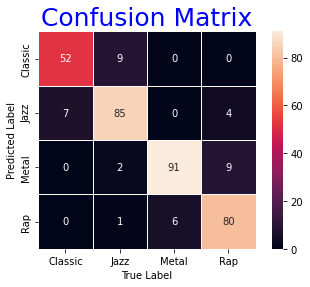

In [145]:
GNB = GaussNaiveBayes()

GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)

confusion_matrix_score(y_test, y_pred)

# for i in list( zip(y_test, y_pred)):
#     print(i, end=' ')

### sk-learn library implementation

The accuracy score is 91.33%.

classification_report: 
              precision    recall  f1-score   support

     Classic       0.93      0.85      0.89        61
        Jazz       0.88      0.86      0.87        96
       Metal       0.94      0.96      0.95       102
         Rap       0.90      0.95      0.93        87

    accuracy                           0.91       346
   macro avg       0.91      0.91      0.91       346
weighted avg       0.91      0.91      0.91       346




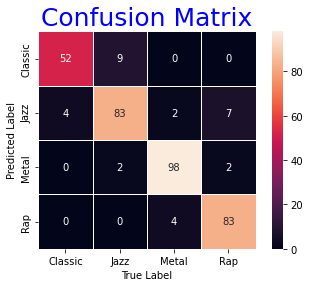

In [146]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(X_train, y_train)
y_pred_2 = clf.predict(X_test)

confusion_matrix_score(y_test, y_pred_2)

# for i in list( zip(y_pred_2, y_pred)):
#     print(i, end=' ')